In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
test_path = '/content/drive/My Drive/circuits/c432.test'

In [4]:
import itertools
import random
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Expand don't-care patterns
def expand_dont_care_limited(pattern, max_expand=15):
    x_indices = [i for i, c in enumerate(pattern) if c == 'x']
    if len(x_indices) <= max_expand:
        chars = [(c if c in '01' else ['0', '1']) for c in pattern]
        chars = [(c if isinstance(c, list) else [c]) for c in chars]
        return [''.join(bits) for bits in itertools.product(*chars)]
    else:
        fixed_pattern = list(pattern)
        patterns = []
        for bits in itertools.product('01', repeat=max_expand):
            temp = fixed_pattern.copy()
            for i, bit in zip(x_indices[:max_expand], bits):
                temp[i] = bit
            for i in x_indices[max_expand:]:
                temp[i] = random.choice('01')
            patterns.append(''.join(temp))
        return patterns

# Parse .faults file (Atalanta format)
def parse_isc_file_limited(filepath, max_expand=3):
    combo_to_fault = {}
    fault_to_idx = {}
    fault_type_map = {}
    idx = 0
    current_fault = None

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if not line or line.startswith("*"):
                continue
            if '/' in line:
                parts = line.split("/")
                fault = parts[0].strip().replace("->", "_") + "/" + parts[1].strip()
                if fault not in fault_to_idx:
                    fault_to_idx[fault] = idx
                    if parts[1].strip() == "0":
                        fault_type_map[idx] = "stuck-at-0"
                    elif parts[1].strip() == "1":
                        fault_type_map[idx] = "stuck-at-1"
                    else:
                        fault_type_map[idx] = "unknown"
                    idx += 1
                current_fault = fault
            elif ':' in line and current_fault:
                parts = line.split(":")[1].strip().split()
                input_pat = parts[0]
                output_pat = parts[1] if len(parts) > 1 else ""
                for xi in expand_dont_care_limited(input_pat, max_expand):
                    for yo in expand_dont_care_limited(output_pat, max_expand):
                        combined = xi + yo
                        if combined not in combo_to_fault:
                            combo_to_fault[combined] = fault_to_idx[current_fault]
    return combo_to_fault, fault_to_idx, fault_type_map

In [5]:
# Custom Dataset
class FaultDatasetMC(Dataset):
    def __init__(self, combo_to_fault):
        self.samples = []
        for combo, label in combo_to_fault.items():
            features = [int(c) for c in combo]
            self.samples.append((features, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return (
            torch.tensor(x, dtype=torch.float32).unsqueeze(1),  # [seq_len, 1]
            torch.tensor(y, dtype=torch.long)
        )

In [6]:
# ANN Classifier
class FaultANNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FaultANNClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.squeeze(1)
        return self.network(x)

In [7]:
combo_to_fault, fault_to_idx, fault_type_map = parse_isc_file_limited(test_path, max_expand=3)
dataset = FaultDatasetMC(combo_to_fault)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_input, _ = dataset[0]
input_size = sample_input.numel()
num_classes = len(fault_to_idx)

model = FaultANNClassifier(input_size=input_size, hidden_size=128, num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(50):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = loss_fn(out, y)
            val_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    val_loss /= len(val_loader)
    accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

# Per-Fault-Type Accuracy
type_correct = defaultdict(int)
type_total = defaultdict(int)

model.eval()
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        preds = out.argmax(dim=1)
        for pred, label in zip(preds.cpu().numpy(), y.cpu().numpy()):
            ftype = fault_type_map[label]
            type_total[ftype] += 1
            if pred == label:
                type_correct[ftype] += 1

# Print fault-type specific accuracy
print("\n--- Fault-Type Accuracy ---")
for ftype in sorted(type_total):
    acc = type_correct[ftype] / type_total[ftype]
    print(f"{ftype}: Accuracy = {acc:.4f} ({type_correct[ftype]}/{type_total[ftype]})")

Epoch 0, Train Loss: 5.2541, Val Loss: 3.9940, Accuracy: 0.1878
Epoch 1, Train Loss: 3.2558, Val Loss: 2.5208, Accuracy: 0.3629
Epoch 2, Train Loss: 2.3977, Val Loss: 2.0120, Accuracy: 0.4523
Epoch 3, Train Loss: 2.0319, Val Loss: 1.7773, Accuracy: 0.4836
Epoch 4, Train Loss: 1.8275, Val Loss: 1.5876, Accuracy: 0.5414
Epoch 5, Train Loss: 1.6818, Val Loss: 1.4571, Accuracy: 0.5719
Epoch 6, Train Loss: 1.5604, Val Loss: 1.3636, Accuracy: 0.5878
Epoch 7, Train Loss: 1.4903, Val Loss: 1.3089, Accuracy: 0.6049
Epoch 8, Train Loss: 1.4098, Val Loss: 1.2400, Accuracy: 0.6169
Epoch 9, Train Loss: 1.3508, Val Loss: 1.2040, Accuracy: 0.6350
Epoch 10, Train Loss: 1.2968, Val Loss: 1.1483, Accuracy: 0.6401
Epoch 11, Train Loss: 1.2533, Val Loss: 1.1172, Accuracy: 0.6513
Epoch 12, Train Loss: 1.2060, Val Loss: 1.0767, Accuracy: 0.6672
Epoch 13, Train Loss: 1.1669, Val Loss: 1.0365, Accuracy: 0.6763
Epoch 14, Train Loss: 1.1195, Val Loss: 1.0060, Accuracy: 0.6805
Epoch 15, Train Loss: 1.0926, Val L

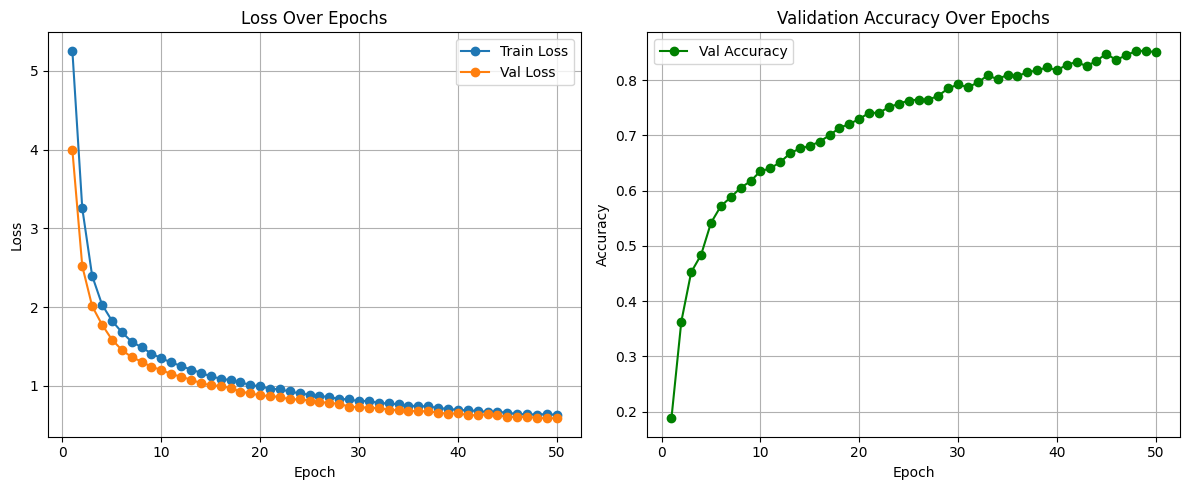

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()